* Competition Name: 1C competition
* Team Name: El freiburgers
* Private Leaderboard Score: 1.019668
* Private Leaderboard Place: 0.999405


* Name: Omar Kassem
* Location: Germany
* Email: omar.kassem67@gmail.com


* Name: Mohamed Abouhussein
* Location:Germany
* Email: abouhussein.mohamed@gmail.com

Required packages:
* numpy, version = '1.18.3'
* pandas, version = '1.0.3'
* matplotlib, version = '3.2.1'
* xgboost, version = '1.0.2'
* sklearn, version = '0.22.2'
* seaborn, version = '0.10.1'

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product
import seaborn as sns

In [2]:
# Loading data
transactions = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

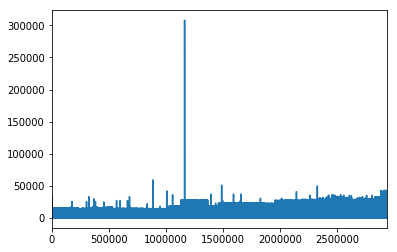

In [3]:
# EDA_1
transactions.item_price.plot()

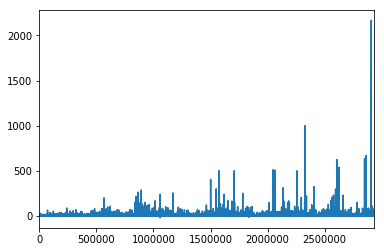

In [4]:
# EDA_2
transactions.item_cnt_day.plot()

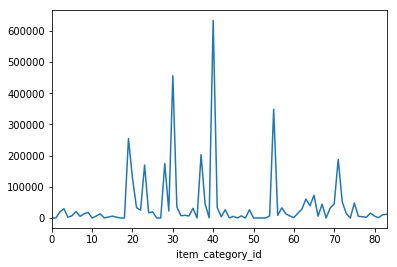

In [5]:
# EDA_3
trans_cat = pd.merge(transactions, items, on='item_id')
grouped_categories = trans_cat.groupby(['item_category_id']).item_cnt_day.sum()
grouped_categories.plot()

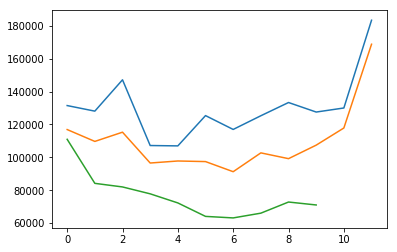

In [6]:
#EDA_4
grouped_months = transactions.groupby(['date_block_num']).item_cnt_day.sum()
plt.plot(grouped_months[:12].to_list())
plt.plot(grouped_months[12:24].to_list())
plt.plot(grouped_months[24:].to_list())

<ul>
    <li>EDA_1 and EDA_2 show few outlier points that should be omitted from the data.</li>
    <li>EDA_3 shows that the item_category can shows the variance of the amount of an item sales.</li>
    <li>EDA_4 shows the annual trend for sales. It is clear that the first year had a higher monthly sales. Thereby, we omit it from the training data and we used its values only for lagged features.  </li>
</ul> 

In [7]:
# Data cleaning based on EDA results to omit outliers
transactions = transactions[transactions.item_price < 10000]
transactions = transactions[transactions.item_cnt_day < 1000]

In [8]:
# Building a combination of all months, items and shops from the transactions data
dateBlocks = transactions['date_block_num'].unique()
grid = []
for date in dateBlocks:
    current_items = transactions.loc[transactions['date_block_num']==date]['item_id'].unique()
    curent_shops = transactions.loc[transactions['date_block_num']==date]['shop_id'].unique()
    grid += list(product(*np.array([[date], current_items, curent_shops])))
grid_list = map(lambda x: list(x), grid)
df = list(grid_list)
labels = ['date_block_num', 'item_id', 'shop_id']
train_grid = pd.DataFrame(df, columns=labels)
#train_grid

In [9]:
# Converting the transactions data into month format
monthly_sales = transactions.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum'], 'item_price':np.mean})
monthly_sales.columns = ["_".join(x) for x in monthly_sales.columns.ravel()]
monthly_sales = monthly_sales.reset_index()
monthly_sales = monthly_sales.rename(columns={"item_cnt_day_sum": "item_cnt_month"})
#monthly_sales

In [10]:
# Calculating monthly sales for the generated grid data
train = pd.merge(train_grid, monthly_sales ,how='left', on=['date_block_num', 'item_id', 'shop_id']).fillna(0)
#train

In [11]:
# Adding item category id to the train data
train = pd.merge(train, items, how='left', on='item_id').drop(['item_name'], axis=1)

In [12]:
# Adding lag features for the train data
shift_range = [1,2,3,6]
index_cols = ['shop_id', 'item_id', 'date_block_num']
cols_to_rename = ['item_cnt_month', 'item_price_mean']
for month_shift in shift_range:
    train_shift = train[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    train = pd.merge(train, train_shift, on=index_cols, how='left').fillna(0)
#train

In [13]:
# Lagged mean and sum of monthly sales of [item, shop, item_category]

# Item 
item_data_copy = train[['item_id', 'date_block_num', 'item_cnt_month', 'item_price_mean']].copy()
item_monthly_cnt = item_data_copy.groupby(['item_id', 'date_block_num']).agg({'item_cnt_month': ['sum', 'mean'], 'item_price_mean':np.mean})
item_monthly_cnt.columns = ["_".join(x) for x in item_monthly_cnt.columns.ravel()]
item_monthly_cnt = item_monthly_cnt.reset_index()

# Shop
shop_data_copy = train[['shop_id', 'date_block_num', 'item_cnt_month', 'item_price_mean']].copy()
shop_monthly_cnt = shop_data_copy.groupby(['shop_id', 'date_block_num']).agg({'item_cnt_month': ['sum', 'mean'], 'item_price_mean':np.mean})
shop_monthly_cnt.columns = ["_".join(x) for x in shop_monthly_cnt.columns.ravel()]
shop_monthly_cnt = shop_monthly_cnt.reset_index()

# Item category
category_data_copy = train[['item_category_id', 'date_block_num', 'item_cnt_month', 'item_price_mean']].copy()
category_monthly_cnt = category_data_copy.groupby(['item_category_id', 'date_block_num']).agg({'item_cnt_month': ['sum', 'mean'], 'item_price_mean':np.mean})
category_monthly_cnt.columns = ["_".join(x) for x in category_monthly_cnt.columns.ravel()]
category_monthly_cnt = category_monthly_cnt.reset_index()

mean_encoding_lag_month = [1,2,3,6]
for month_shift in mean_encoding_lag_month:
    # Item lag
    item_shift = item_monthly_cnt.copy()
    item_shift['date_block_num'] = item_shift['date_block_num'] + month_shift
    item_shift = item_shift.rename(columns = {'item_cnt_month_mean': 'item_avg_lag_'+str(month_shift),
                                              'item_cnt_month_sum': 'item_sum_lag_'+str(month_shift),
                                              'item_price_mean_mean': 'item_avg_price_month_lag_'+str(month_shift)})
    # Shop lag
    shop_shift = shop_monthly_cnt.copy()
    shop_shift['date_block_num'] = shop_shift['date_block_num'] + month_shift
    shop_shift = shop_shift.rename(columns = {'item_cnt_month_mean': 'shop_avg_lag_'+str(month_shift),
                                              'item_cnt_month_sum': 'shop_sum_lag_'+str(month_shift),
                                              'item_price_mean_mean': 'shop_avg_prices_lag_'+str(month_shift)})
    
    # Item category lag
    category_shift = category_monthly_cnt.copy()
    category_shift['date_block_num'] = category_shift['date_block_num'] + month_shift
    category_shift = category_shift.rename(columns = {'item_cnt_month_mean': 'category_avg_lag_'+str(month_shift),
                                              'item_cnt_month_sum': 'category_sum_lag_'+str(month_shift),
                                              'item_price_mean_mean': 'category_avg_price_month_lag_'+str(month_shift)})
    
    # Merging lags
    train = pd.merge(train, item_shift, on=['item_id', 'date_block_num'], how='left').fillna(0)
    train = pd.merge(train, shop_shift, on=['shop_id', 'date_block_num'], how='left').fillna(0)
    train = pd.merge(train, category_shift, on=['item_category_id', 'date_block_num'], how='left').fillna(0)    

In [14]:
# Removing rows from the first year
train = train.loc[train['date_block_num']>12]

# Adding month col
train['month'] = (train['date_block_num'] % 12) + 1

# Adding season col
dict_season = {12: 1, 1: 1, 2:1, 3: 2, 4: 2, 5: 2, 6: 3,
               7: 3, 8: 3, 9: 4, 10: 4, 11: 4}
train['season'] = train['month'].map(dict_season)

In [15]:
# Checking that there is no nans in train data 
print(train.isna().sum())
# Clipping the data labels in the range of (0, 40) 
train['item_cnt_month'] = train['item_cnt_month'].clip(0, 40)

date_block_num                    0
item_id                           0
shop_id                           0
item_cnt_month                    0
item_price_mean                   0
item_category_id                  0
item_cnt_month_lag_1              0
item_price_mean_lag_1             0
item_cnt_month_lag_2              0
item_price_mean_lag_2             0
item_cnt_month_lag_3              0
item_price_mean_lag_3             0
item_cnt_month_lag_6              0
item_price_mean_lag_6             0
item_sum_lag_1                    0
item_avg_lag_1                    0
item_avg_price_month_lag_1        0
shop_sum_lag_1                    0
shop_avg_lag_1                    0
shop_avg_prices_lag_1             0
category_sum_lag_1                0
category_avg_lag_1                0
category_avg_price_month_lag_1    0
item_sum_lag_2                    0
item_avg_lag_2                    0
item_avg_price_month_lag_2        0
shop_sum_lag_2                    0
shop_avg_lag_2              

In [16]:
# Preprocessing test data

# Adding item category
test = test.merge(items, on='item_id', how='left')

# Adding date features
test['date_block_num'] = 34
test['month'] = 11
test['season'] = 4

In [17]:
# Adding lag features
train_data_lag = train.loc[train['date_block_num'] >= 34 - shift_range[-1]]
for month_shift in shift_range:
    train_shift = train_data_lag[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    test = pd.merge(test, train_shift, on=index_cols, how='left').fillna(0)


In [18]:
# Lagged mean and sum of monthly sales of [item, shop, item_category]

for month_shift in mean_encoding_lag_month:
    # Item lag
    item_shift = item_monthly_cnt.copy()
    item_shift['date_block_num'] = item_shift['date_block_num'] + month_shift
    item_shift = item_shift.rename(columns = {'item_cnt_month_mean': 'item_avg_lag_'+str(month_shift),
                                              'item_cnt_month_sum': 'item_sum_lag_'+str(month_shift),
                                              'item_price_mean_mean': 'item_avg_price_month_lag_'+str(month_shift)})
    
    # Shop lag
    shop_shift = shop_monthly_cnt.copy()
    shop_shift['date_block_num'] = shop_shift['date_block_num'] + month_shift
    shop_shift = shop_shift.rename(columns = {'item_cnt_month_mean': 'shop_avg_lag_'+str(month_shift),
                                              'item_cnt_month_sum': 'shop_sum_lag_'+str(month_shift),
                                              'item_price_mean_mean': 'shop_avg_prices_lag_'+str(month_shift)})
   
    # Item category lag
    category_shift = category_monthly_cnt.copy()
    category_shift['date_block_num'] = category_shift['date_block_num'] + month_shift
    category_shift = category_shift.rename(columns = {'item_cnt_month_mean': 'category_avg_lag_'+str(month_shift),
                                              'item_cnt_month_sum': 'category_sum_lag_'+str(month_shift),
                                              'item_price_mean_mean': 'category_avg_price_month_lag_'+str(month_shift)})
    
    # Merging lags
    test = pd.merge(test, item_shift, on=['item_id', 'date_block_num'], how='left').fillna(0)
    test = pd.merge(test, shop_shift, on=['shop_id', 'date_block_num'], how='left').fillna(0)
    test = pd.merge(test, category_shift, on=['item_category_id', 'date_block_num'], how='left').fillna(0)

In [19]:
# Checking that there is no nans in test data
print(test.isna().sum())

ID                                0
shop_id                           0
item_id                           0
item_name                         0
item_category_id                  0
date_block_num                    0
month                             0
season                            0
item_cnt_month_lag_1              0
item_price_mean_lag_1             0
item_cnt_month_lag_2              0
item_price_mean_lag_2             0
item_cnt_month_lag_3              0
item_price_mean_lag_3             0
item_cnt_month_lag_6              0
item_price_mean_lag_6             0
item_sum_lag_1                    0
item_avg_lag_1                    0
item_avg_price_month_lag_1        0
shop_sum_lag_1                    0
shop_avg_lag_1                    0
shop_avg_prices_lag_1             0
category_sum_lag_1                0
category_avg_lag_1                0
category_avg_price_month_lag_1    0
item_sum_lag_2                    0
item_avg_lag_2                    0
item_avg_price_month_lag_2  

In [20]:
# Dropping the item_price_mean as it can not be generated for test data 
train = train.drop(['item_price_mean'], axis=1)

# Training models (not using linear models)
* Several models were tested this mainly includes xgboost, random forests and Linear regressor
* The xgboost model outperformed the other tested models. Therefore, it was the only one used and the rest were ommitted

In [21]:
models = []
fold_val_error = []
num_folds = 5
last_block = 34
curr_block = last_block - num_folds
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}
while curr_block < last_block:
    print('training fold number {} out of {}'.format(curr_block - (last_block - num_folds - 1), num_folds))
    x_train_fold = train.loc[train['date_block_num'] < curr_block, train.columns != 'item_cnt_month']
    y_train_fold = train.loc[train['date_block_num'] < curr_block, train.columns == 'item_cnt_month']
    x_test_fold = train.loc[train['date_block_num'] == curr_block, train.columns != 'item_cnt_month']
    y_test_fold = train.loc[train['date_block_num'] == curr_block, train.columns == 'item_cnt_month']
    x_test_fold = x_test_fold[x_train_fold.columns]
    xgbtrain = xgb.DMatrix(x_train_fold.values, y_train_fold.values)
    bst = xgb.train(param, xgbtrain)
    pred = bst.predict(xgb.DMatrix(x_test_fold.values))
    pred = np.clip(pred, a_min=0, a_max=20)
    fold_val_error += [np.sqrt(mean_squared_error(y_test_fold, pred))]
    print('fold training finished with validation error ', fold_val_error[-1])
    models += [bst]
    curr_block += 1

training fold number 1 out of 5
[17:00:09] WARNING: C:\Users\Administrator\Desktop\xgboost\src\learner.cc:685: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
fold training finished with validation error  1.0020308280701413
training fold number 2 out of 5
[17:06:09] WARNING: C:\Users\Administrator\Desktop\xgboost\src\learner.cc:685: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
fold training finished with validation error  0.8281049205474446
training fold number 3 out of 5
[17:12:53] WARNING: C:\Users\Administrator\Desktop\xgboost\src\learner.cc:685: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
fold training finished with validation error  0.

In [22]:
# Average rmse score on the 5 folds
np.mean(fold_val_error)

1.0056482316132782

In [23]:
X_test = test.loc[:, test.columns != 'ID'][x_test_fold.columns]
y_pred = models[-1].predict(xgb.DMatrix(X_test.values))
y_pred = np.clip(y_pred, a_min=0, a_max=20)

In [24]:
# Saving the predictions to a csv file
sub = {'ID':test['ID'].to_list(), 'item_cnt_month':y_pred}
df = pd.DataFrame(sub)
df.to_csv('test_pred.csv', index=False)